In [1]:
import numpy as np
from trapanalysis import TrapGetter
import tifffile as tf 
from qtpy import QtWidgets, QtCore
from keras.models import load_model
import time
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from Watchbackvideos import livestream
import qimage2ndarray as qnd
from AnnotatedVidViewer import TrapViewer
import pandas as pd
from seaborn import heatmap
from HeatPlotGenerator import HeatPlotGenerator

Using TensorFlow backend.


In [2]:
class Analyser(object):

    def __init__(self,path):
        self.videopath =path
        self.frames = None
        


        #data repositories

        self.intensitytrace = {}
        self.bg_sub_intensity_trace = {}
        
        self.areatrace = {}
        self.areaerrors = {}
        self.centres = {}
        
        self.trapgetter = TrapGetter()
        
        self.visibletrapframe = None

        self.classifier = load_model('VesClassifier')
        self.mask = np.array([])
        self.t0frameNo = 0
        
        self.vesiclelife = None
        
        self.missing_peaks = {}
        
        self.livestream = None
        self.duplicates = np.array([])
        
        self.bgintens = None
        self.heat_data = np.array([])
        self.HPG = HeatPlotGenerator()
        
    def load_frames(self):

        with tf.TiffFile(self.videopath) as tif:
            self.frames = tif.asarray()
        print('Done!')
        
        
        
        
    def get_traps(self):
        #for now assumes that the traps are visible in last frame of video. Could also add feature for user
        #selection but that will limit the speed of automated analysis

        self.visibletrapframe = self.frames[-1]
        
        self.trapgetter.get_trap_positions(self.visibletrapframe)
        
        self.trapgetter.remove_duplicates() 

    def rectangle(self,start, end=None, extent=None, shape=None):
    
        if extent is not None:
            end = np.array(start) + np.array(extent)
        elif end is None:
            raise ValueError("Either `end` or `extent` must be given")
        tl = np.minimum(start, end)
        br = np.maximum(start, end)
        if extent is None:
            br += 1
        if shape is not None:
           br = np.minimum(shape, br)
           tl = np.maximum(np.zeros_like(shape), tl)
        coords = np.meshgrid(*[np.arange(st, en) for st, en in zip(tuple(tl),
                                                           tuple(br))])
                                                           
        return np.vstack((coords[0].flatten(),coords[1].flatten()))

    def get_clips(self):

        counter = 0
        for trap in self.trapgetter.trap_positions:
            
            if self.mask.shape[0] >0:
                
                try:
                    self.mask = np.vstack((self.mask,self.rectangle(start = trap-[self.trapgetter.topboxrel,self.trapgetter.leftboxrel],end = trap +[self.trapgetter.bottomboxrel,self.trapgetter.rightboxrel])))
                except:
                    continue
            else:
                    self.mask = self.rectangle(start = trap-[self.trapgetter.topboxrel,self.trapgetter.leftboxrel],end = trap +[self.trapgetter.bottomboxrel,self.trapgetter.rightboxrel])

            counter +=1
        print(counter)
        self.mask = self.mask.reshape(int(self.mask.shape[0]/2),2,self.mask.shape[1])
    
    def get_clips_alt(self):
        
        for trap in self.trapgetter.trap_positions:
            clip = np.zeros_like(self.frames[0])
            
            try:
                clip[self.rectangle(start = trap-[self.trapgetter.topboxrel,self.trapgetter.leftboxrel],end = trap +[self.trapgetter.bottomboxrel,self.trapgetter.rightboxrel])[0],self.rectangle(start = trap-[self.trapgetter.topboxrel,self.trapgetter.leftboxrel],end = trap +[self.trapgetter.bottomboxrel,self.trapgetter.rightboxrel])[1]]=1
            except:
                continue
            if self.mask.shape[0] > 0:
                self.mask = np.vstack((self.mask,clip.flatten()))
            else:
                self.mask = clip.flatten()
                
                
    def sett0frame(self,frameno):
        
        self.t0frameNo = int(frameno)
    def classify_clips(self):
        
        #classify contents of boxes in t = 0 frame, and then switch off recording for initially empty boxes
        initial_frame = self.frames[self.t0frameNo]
        
        
        self.clips = initial_frame.flatten().T*self.mask
        
        self.clips = self.clips[self.clips >0].reshape(self.clips.shape[0],31,31)
        
        self.clips -= np.min(self.clips)
        
        self.clips = self.clips/np.max(self.clips)
        
        self.class_labels = self.classifier.predict(self.clips[:,:30,:30,np.newaxis],batch_size = self.clips.shape[0])
        
        self.class_labels = self.class_labels.reshape(self.class_labels.shape[0],)
        
        
    def process_clips(self,clips):
        
        clips -= np.min(clips)
        
        clips = clips/np.max(clips)
        
        return clips
    
        
    def analyse_frames(self,maxframe):

            
        self.active_labels = self.trapgetter.labels[self.class_labels.astype(int) == 1]
        self.activemask = self.mask[self.class_labels.astype(int) == 1]
        
        counter = 0
        for frame in self.frames[self.t0frameNo:maxframe]:
            
            tic = time.time()
            
            self.clips = frame.flatten().T*self.activemask
            
            self.clips = self.clips[self.clips >0].reshape(self.clips.shape[0],31,31)
            
            self.zerominclips = self.clips - np.min(self.clips) 
            
            self.zero2oneclips = self.zerominclips/np.max(self.zerominclips)
            
            self.class_labels = self.classifier.predict(self.zero2oneclips[:,:30,:30,np.newaxis],batch_size = self.clips.shape[0])
            
            self.class_labels = self.class_labels.reshape(self.class_labels.shape[0],)

            for label in self.active_labels:
                self.extract_intensity(label,counter)
                
                
            self.active_labels = self.active_labels[self.class_labels.astype(int) == 1]
            
            
            
            self.activemask = self.activemask[self.class_labels.astype(int) == 1]
    
            toc = time.time()
            
            print(len(self.active_labels), 'time taken is: '+ str(toc -tic))
            counter +=1
           
    def visualise_active_clips(self,num = 3):
        
        number_of_samples = num       
        
        idxs = np.arange(self.active_labels.shape[0])
        if idxs.shape[0] >0:
            idxs = np.random.choice(idxs, number_of_samples, replace=False)
            for i, idx in enumerate(idxs):
                plt.subplot(number_of_samples, 1, i+1)
                plt.imshow(self.clips[idx],cmap = 'gray')
                
                plt.xlabel('Active Clip')
                
                
                if i == 0:
                    plt.title('Active Boxes detected by Classifier')
    
        plt.tight_layout()
        plt.show()
                
    def extract_background_intensity(self):
        self.bgoffset = [int(0.5*np.median(self.trapgetter.distances[np.arange(self.trapgetter.distances.shape[0]),self.trapgetter.sorted_distances[:,1]][self.trapgetter.distances[np.arange(self.trapgetter.distances.shape[0]),self.trapgetter.sorted_distances[:,1]] > 10])),0]
        self.bgcentrecoords = self.trapgetter.trap_positions[self.trapgetter.labels == 0][0] - self.bgoffset
        
        self.bgintens = np.average(A.frames[:,self.bgcentrecoords[0]-3:self.bgcentrecoords[0]+3,self.bgcentrecoords[1]-3:self.bgcentrecoords[1]+3],axis = (1,2))
        
    def extract_background(self,maxlen):
        self.bgintens = np.average(A.frames[maxlen+1:])
        
    def extract_intensity(self,label,counter):
        
        threshold = threshold_otsu(self.clips[self.active_labels == label])
        
        testclip = np.zeros_like(self.clips[self.active_labels == label].reshape(31,31))
        
        testclip[self.clips[self.active_labels == label].reshape(31,31) > threshold] = 1
        
        try:
            self.areatrace[str(label)].append(len(testclip[testclip >0]))
        except KeyError:
            self.areatrace[str(label)] = [len(testclip[testclip >0])]
            
        dt = distance_transform_edt(testclip)
        
        try:
            centre = peak_local_max(dt,threshold_rel = 0.6)[0]
            
        except IndexError:
            centre = []
            try:
                self.missing_peaks[str(label)].append(counter)
            except KeyError:
                self.missing_peaks[str(label)] = [counter]
          
            
            
        if len(centre) >0:
            
            av_intens = np.average(self.clips[self.active_labels == label][0][centre[0]-4:centre[0]+4,centre[1]-4:centre[1]+4])
        
            try:
            
                self.intensitytrace[str(label)].append(av_intens)
            except KeyError:
                self.intensitytrace[str(label)] = [av_intens]
            
            try:
                self.centres[str(label)].append(centre)
            except KeyError:
                self.centres[str(label)] = [centre]    
        
        
        
        
    def visualise_box_contents(self,label):
        
        trap = self.trapgetter.trap_positions[self.trapgetter.labels == label][0]
        
        
        clip = np.zeros_like(self.frames[0])
        
        try:
            clip[self.rectangle(start = trap-[self.trapgetter.topboxrel,self.trapgetter.leftboxrel],end = trap +[self.trapgetter.bottomboxrel,self.trapgetter.rightboxrel])[0],self.rectangle(start = trap-[self.trapgetter.topboxrel,self.trapgetter.leftboxrel],end = trap +[self.trapgetter.bottomboxrel,self.trapgetter.rightboxrel])[1]]=1

        except:
            raise IndexError
            
        
        self.vesiclelife = self.frames.reshape(self.frames.shape[0],self.frames.shape[1]*self.frames.shape[2])*clip.flatten()
        
        self.vesiclelife = self.vesiclelife[self.vesiclelife !=0]
        
        self.vesiclelife = self.vesiclelife.reshape(self.frames.shape[0],31,31)
        
        
    def plotnow(self,label):
        self.plotIAforaves(30*np.arange(len(self.areatrace[str(label)])),self.areatrace[str(label)],30*np.arange(len(self.bg_sub_intensity_trace[str(label)])),self.bg_sub_intensitytrace[str(label)])
    def plotIAforaves(self,xdataA,ydataA,xdataI= None,ydataI = None):
        
        
        plt.figure()
        if xdataI:
                
            plt.subplot(211)
            plt.title('Plot of Area (top) and Average Inner Intensity (below) \n against Frame Number for a Randomly Chosen Vesicle')
            plt.ylabel('Area /Pixels')
            plt.yticks([int(np.min(ydataA)),int(0.5*(np.max(ydataA)-np.min(ydataA))),int(np.max(ydataA))])
            plt.xticks(np.array([0,int(len(ydataI)),len(ydataI)])*30) 
    
            plt.plot(xdataA,ydataA)
    
            plt.subplot(212)
            plt.ylabel('Intensity/arbitrary units')
            plt.yticks([int(np.min(ydataI)),int(0.5*(np.max(ydataI)-np.min(ydataI))),int(np.max(ydataI))])
            plt.xticks(np.array([0,int(len(ydataI)/2),len(ydataI)])*30) 
            plt.xlabel('Time since T0/s')
            plt.plot(xdataI,ydataI)
            
            plt.tight_layout()
        
        else:
            plt.subplot(111)
            plt.plot(xdataA,ydataA)
            
    def viewstream(self,label,tmax,video,t0= None,annotations = True):
        if not t0:
            t0 = self.t0frameNo
            
        self.ls = livestream(qnd,video[t0:tmax],annotations_on = annotations,annotate_coords = self.centres[str(label)])
       
        
    def subtract_background(self):
        
        for key in self.intensitytrace.keys():
            self.bg_sub_intensity_trace[key] = np.array(self.intensitytrace[key])-self.bgintens
            
            
    def heat_data_generator(self):
        maxlen = -1
        for key in self.bg_sub_intensity_trace.keys():
            length = self.bg_sub_intensity_trace[key].shape[0]
            if length > maxlen:
                maxlen = length
            
        for key in self.bg_sub_intensity_trace.keys():
        
            if self.heat_data.shape[0] == 0:
                self.heat_data = np.concatenate((self.bg_sub_intensity_trace[key],np.zeros((maxlen-self.bg_sub_intensity_trace[key].shape[0],))))
            else:
                
                self.heat_data = np.vstack((self.heat_data,np.concatenate((self.bg_sub_intensity_trace[key],np.zeros((maxlen-self.bg_sub_intensity_trace[key].shape[0],))))))
        lengths = []
        
        for i  in range(0,self.heat_data.shape[0]):
            self.heat_data[i,:] = self.heat_data[i,:]/self.heat_data[i,0]
            array = self.heat_data[i,:]
            
            lengths.append(array[array > 0.5].shape[0])    
            
        lengths = np.array(lengths)
        
        
        self.heat_data_ordered = self.heat_data[np.argsort(lengths)]
        
        self.times = 30*np.arange(self.heat_data_ordered.shape[0])
        
    def get_heat_plot(self):
        
        self.HPG.generate(self.times,self.heat_data_ordered,'Plot of the fluorescent intensities of trapped vesicles\n against time after being subject to the drug')
        
        

In [3]:
    A = Analyser('/Users/MarcusF/Desktop/TrapAnalysis/260522_CecB-  PCPG vesicles- after flushing_1_MMStack_Pos6.ome.tif')
    A.load_frames()
    A.get_traps()
    A.get_clips_alt()
    A.sett0frame(400)
    A.classify_clips()
    A.analyse_frames(965)
    A.extract_background(965)
    A.subtract_background()
    A.heat_data_generator()

/Users/MarcusF/anaconda3/lib/python3.6/site-packages/tifffile/tifffile.py:2236: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn('ome-xml: not an ome-tiff master file')


Done!
75 time taken is: 1.7065849304199219
75 time taken is: 1.092353105545044
75 time taken is: 0.5021047592163086
75 time taken is: 0.4800839424133301
75 time taken is: 0.542504072189331
75 time taken is: 0.36571431159973145
75 time taken is: 0.3282299041748047
75 time taken is: 0.3252530097961426
75 time taken is: 0.36484503746032715
75 time taken is: 0.18580102920532227
75 time taken is: 0.20523881912231445
75 time taken is: 0.1905992031097412
75 time taken is: 0.1827857494354248
75 time taken is: 0.17917490005493164
75 time taken is: 0.20591497421264648
75 time taken is: 0.18833708763122559
75 time taken is: 0.21936893463134766
75 time taken is: 0.18562674522399902
75 time taken is: 0.2131502628326416
75 time taken is: 0.16833782196044922
75 time taken is: 0.20936322212219238
75 time taken is: 0.2661311626434326
75 time taken is: 0.28402185440063477
75 time taken is: 0.18742704391479492
75 time taken is: 0.17943906784057617
75 time taken is: 0.19546294212341309
75 time taken is: 0

71 time taken is: 0.1665477752685547
71 time taken is: 0.15944814682006836
70 time taken is: 0.17556309700012207
70 time taken is: 0.17722225189208984
70 time taken is: 0.18903517723083496
70 time taken is: 0.17523193359375
70 time taken is: 0.17367792129516602
70 time taken is: 0.16507911682128906
70 time taken is: 0.18189382553100586
70 time taken is: 0.17495512962341309
70 time taken is: 0.18580293655395508
70 time taken is: 0.17710590362548828
70 time taken is: 0.16259479522705078
69 time taken is: 0.16265106201171875
69 time taken is: 0.17599987983703613
69 time taken is: 0.14829277992248535
69 time taken is: 0.1559758186340332
69 time taken is: 0.1653280258178711
69 time taken is: 0.17565274238586426
69 time taken is: 0.16196107864379883
69 time taken is: 0.15288496017456055
69 time taken is: 0.15967202186584473
69 time taken is: 0.17600178718566895
69 time taken is: 0.16235899925231934
69 time taken is: 0.22278785705566406
68 time taken is: 0.15525293350219727
68 time taken is: 

25 time taken is: 0.08965396881103516
25 time taken is: 0.08912777900695801
24 time taken is: 0.08342599868774414
23 time taken is: 0.06527590751647949
23 time taken is: 0.07149291038513184
22 time taken is: 0.06397509574890137
22 time taken is: 0.09838294982910156
22 time taken is: 0.09106779098510742
22 time taken is: 0.12850403785705566
22 time taken is: 0.06437420845031738
21 time taken is: 0.06351399421691895
21 time taken is: 0.057739973068237305
21 time taken is: 0.08081698417663574
21 time taken is: 0.07770013809204102
19 time taken is: 0.07937502861022949
19 time taken is: 0.08194613456726074
19 time taken is: 0.046816110610961914
19 time taken is: 0.04597616195678711
19 time taken is: 0.047885894775390625
19 time taken is: 0.051032066345214844
19 time taken is: 0.049060821533203125
19 time taken is: 0.0540311336517334
19 time taken is: 0.0766150951385498
19 time taken is: 0.06407690048217773
19 time taken is: 0.08359313011169434
18 time taken is: 0.060121774673461914
18 time 

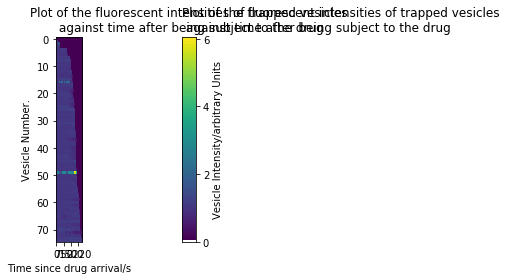

In [4]:
A.get_heat_plot()

In [4]:
A.plotIAforaves(A.times,A.areatrace,xdataI = A.times,ydataI=A.bg_sub_intensity_trace,)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 432x288 with 0 Axes>

In [6]:
np.savetxt('/Users/MarcusF/Desktop/TrapAnalysis/times.txt',A.times)
np.savetxt('/Users/MarcusF/Desktop/TrapAnalysis/ordered_ves_intens.txt',A.heat_data_ordered)

<Figure size 432x288 with 0 Axes>

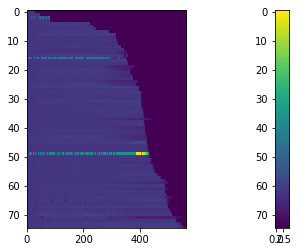

In [21]:
plt.figure()
fig,(ax,heatbar) = plt.subplots(1,2)


plt.subplots_adjust(wspace = 0.1,hspace = 0)

ax.imshow(A.heat_data_ordered,aspect = "auto")

heatbar_data = np.linspace(np.min(A.heat_data_ordered),np.max(A.heat_data_ordered),A.heat_data_ordered.shape[0])
                           
heatbar_data = np.tile(heatbar_data,(5,1))

heatbar_data = heatbar_data.T[::-1]

heatbar.imshow(heatbar_data)

In [22]:
A.visualise_box_contents(31)

In [7]:
A.viewstream(31,965,A.vesiclelife)

TypeError: 'NoneType' object is not subscriptable

In [4]:
import pandas as pd


In [5]:
pd.DataFrame.from_dict(A.intensitytrace).fillna('')

ValueError: arrays must all be same length

In [6]:
df = pd.DataFrame.from_dict(A.intensitytrace, orient='index').transpose().fillna('')

In [7]:
df\

,0,2,5,7,9,10,11,12,14,16,...,80,81,82,83,84,87,88,91,92,94
0,3359.28,3080.86,2391.3,2803.06,4927.27,2828.67,3265,3403.33,5347.77,2886.45,...,3770.58,4717.67,5766.52,5589.25,5470.8,4318.98,3400.84,1817.2,4371.8,2371.92
1,3313.28,3088.81,2406.34,2780.83,4875.14,2917.92,3303.91,3349.7,5343.3,2919.84,...,3769.05,4752.53,5814.02,5608.86,5516.06,4440.72,3423.98,1819.88,4363.56,2335.2
2,3303.19,3050.16,2402.36,2941.41,4949.64,2792.97,3275.75,3343.59,5349.28,2914.84,...,3748.19,4579.59,5799,5652.5,5496.89,4415.25,3376.91,1772.47,4374.53,2368.16
3,3282.47,3089.7,2313.48,2745.59,4823.44,2838.48,3232.81,3375.48,5263.67,2938.03,...,3824.16,4598.42,5720.33,5676.92,5502.16,4400.56,3408.22,1814.3,4348.52,2299.98
4,3296.11,3037.14,2399.73,2793.17,4883.47,2854.14,3207.59,3253.86,5328.64,2926.66,...,3799.75,4563.42,5717.08,5681.09,5460.45,4288.66,3457.62,1800.78,4290.45,2378.41
5,3343.58,3075.2,2417.83,2942.88,4930.8,2858.06,3243.05,3387.81,5282.92,2894.36,...,3707.66,4668.11,5760.34,5608.14,5508.3,4423.75,3398.67,1752.06,4357.72,2352.78
6,3362.86,3067.03,2397.66,3004.67,4950.77,2840.53,3183.97,3337.88,5276.44,2946.02,...,3719.77,4655.83,5879.83,5639.27,5482.67,4385.06,3406.73,1794.64,4354.83,2328.09
7,3394.67,3060.58,2452.72,3325.09,4933,2880.27,3260.89,3395.34,5308.75,2933.89,...,3805.41,4656.78,5829.92,5707.42,5574.16,4468.55,3419.47,1810.12,4294.42,2293.08
8,3313.97,3088.39,2463.7,2923.83,4953.88,2907.25,3224.94,3353.06,5305.62,2926.19,...,3735.8,4570.34,5760.31,5737.64,5435.91,4413.17,3411.59,1785.25,4313.98,2294.66
9,3341.69,3077.86,2412.12,2783.58,4901.06,2820.33,3277.41,3339.94,5336.2,2938.89,...,3754.19,4607.33,5836.91,5646.05,5527.97,4383.98,3448.48,1760.98,4409.38,2397.2


In [8]:
df

,0,2,5,7,9,10,11,12,14,16,...,80,81,82,83,84,87,88,91,92,94
0,3359.28,3080.86,2391.3,2803.06,4927.27,2828.67,3265,3403.33,5347.77,2886.45,...,3770.58,4717.67,5766.52,5589.25,5470.8,4318.98,3400.84,1817.2,4371.8,2371.92
1,3313.28,3088.81,2406.34,2780.83,4875.14,2917.92,3303.91,3349.7,5343.3,2919.84,...,3769.05,4752.53,5814.02,5608.86,5516.06,4440.72,3423.98,1819.88,4363.56,2335.2
2,3303.19,3050.16,2402.36,2941.41,4949.64,2792.97,3275.75,3343.59,5349.28,2914.84,...,3748.19,4579.59,5799,5652.5,5496.89,4415.25,3376.91,1772.47,4374.53,2368.16
3,3282.47,3089.7,2313.48,2745.59,4823.44,2838.48,3232.81,3375.48,5263.67,2938.03,...,3824.16,4598.42,5720.33,5676.92,5502.16,4400.56,3408.22,1814.3,4348.52,2299.98
4,3296.11,3037.14,2399.73,2793.17,4883.47,2854.14,3207.59,3253.86,5328.64,2926.66,...,3799.75,4563.42,5717.08,5681.09,5460.45,4288.66,3457.62,1800.78,4290.45,2378.41
5,3343.58,3075.2,2417.83,2942.88,4930.8,2858.06,3243.05,3387.81,5282.92,2894.36,...,3707.66,4668.11,5760.34,5608.14,5508.3,4423.75,3398.67,1752.06,4357.72,2352.78
6,3362.86,3067.03,2397.66,3004.67,4950.77,2840.53,3183.97,3337.88,5276.44,2946.02,...,3719.77,4655.83,5879.83,5639.27,5482.67,4385.06,3406.73,1794.64,4354.83,2328.09
7,3394.67,3060.58,2452.72,3325.09,4933,2880.27,3260.89,3395.34,5308.75,2933.89,...,3805.41,4656.78,5829.92,5707.42,5574.16,4468.55,3419.47,1810.12,4294.42,2293.08
8,3313.97,3088.39,2463.7,2923.83,4953.88,2907.25,3224.94,3353.06,5305.62,2926.19,...,3735.8,4570.34,5760.31,5737.64,5435.91,4413.17,3411.59,1785.25,4313.98,2294.66
9,3341.69,3077.86,2412.12,2783.58,4901.06,2820.33,3277.41,3339.94,5336.2,2938.89,...,3754.19,4607.33,5836.91,5646.05,5527.97,4383.98,3448.48,1760.98,4409.38,2397.2
